In [10]:
!!pip install imutils

['Collecting imutils',
 '  Downloading imutils-0.5.4.tar.gz (17 kB)',
 'Building wheels for collected packages: imutils',
 '  Building wheel for imutils (setup.py): started',
 "  Building wheel for imutils (setup.py): finished with status 'done'",
 '  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=8fba9f0c1ad05f1687d1b494c97437efd09a32b1d37cf91bb0dbb49415705b3a',
 '  Stored in directory: c:\\users\\atharva p deshpande\\appdata\\local\\pip\\cache\\wheels\\59\\1b\\52\\0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89',
 'Successfully built imutils',
 'Installing collected packages: imutils',
 'Successfully installed imutils-0.5.4']

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import tqdm
import random
import tensorflow
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import MaxPooling2D, Activation, Dropout
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from keras.backend import image_data_format
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from glob import glob
import datetime as dt
import numpy as np
import cv2
import os
import imutils
%matplotlib inline
warnings.filterwarnings('ignore')

In [12]:
input_path = []
label = []

for class_name in os.listdir("brain_tumor_dataset/train"):
    for path in os.listdir("brain_tumor_dataset/train/"+class_name):
        if class_name == 'yes':
            label.append(1)
        else:
            label.append(0)
        input_path.append(os.path.join("brain_tumor_dataset/train", class_name, path))
print(input_path[0], label[0])

brain_tumor_dataset/train\no\1 no.jpeg 0


In [14]:
df = pd.DataFrame()
df['images'] = input_path
df['label'] = label
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,images,label
0,brain_tumor_dataset/train\no\no_0_7259.jpg,0
1,brain_tumor_dataset/train\yes\yes_0_4776.jpg,1
2,brain_tumor_dataset/train\no\no_0_5676.jpg,0
3,brain_tumor_dataset/train\yes\yes_0_4242.jpg,1
4,brain_tumor_dataset/train\no\no_0_2625.jpg,0


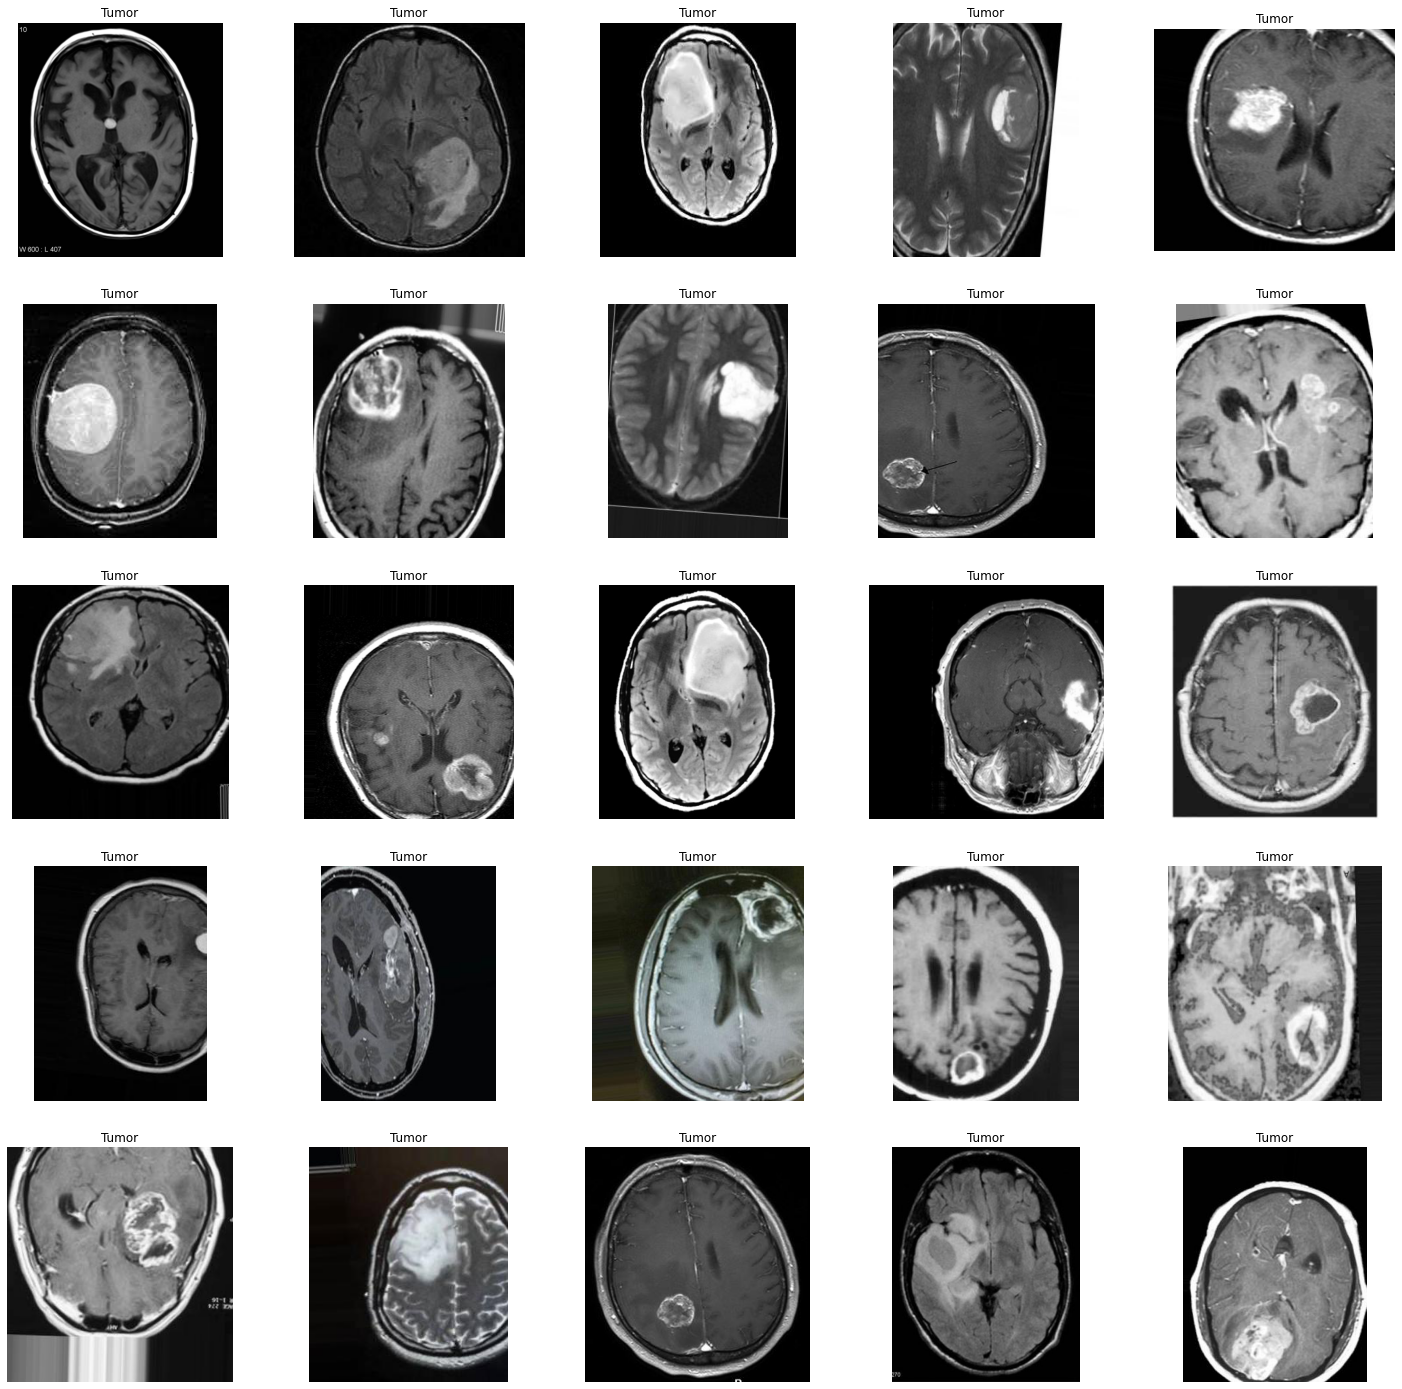

In [15]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==1]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Tumor')
    plt.axis('off')

In [4]:
# to display grid of images
plt.figure(figsize=(25,25))
temp = df[df['label']==0]['images']
start = random.randint(0, len(temp))
files = temp[start:start+25]

for index, file in enumerate(files):
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title('Normal')
    plt.axis('off')

KeyError: 'label'

<Figure size 1800x1800 with 0 Axes>

In [50]:
train_path = r'brain_tumor_dataset/train'
test_path = r'brain_tumor_dataset/test'

In [51]:
os.listdir(train_path), os.listdir(test_path)

(['no', 'yes'], ['no', 'yes'])

In [52]:
# creating Image generator to create more data samples
train_gen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.25,
            fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1./255)

def create_sample_dataset(train_path, test_path, train_samples=0, test_samples=0):
    # creating samples for training data
    for fold in os.listdir(train_path):
        for t_img in glob(train_path + '/' + fold + '/*.jpg'):
            img = img_to_array(load_img(t_img))
            img = img.reshape((1,) + img.shape)
            i = 0
            for batch in train_gen.flow(img, 
                                         batch_size=1,
                                         save_to_dir=train_path + '/' + fold,
                                         save_prefix=fold,
                                         save_format='jpg'):
                if i == 10:
                    break
                i += 1


    # creating samples for testing data
    for fold in os.listdir(test_path):
        for t_img in glob(test_path + '/' + fold + '/*.jpg'):
            img = img_to_array(load_img(t_img))
            img = img.reshape((1, ) + img.shape)
            i = 0
            for batch in test_gen.flow(img, 
                                         batch_size=1,
                                         save_to_dir=test_path + '/' + fold,
                                         save_prefix=fold,
                                         save_format='jpg'):
                if i == 10:
                    break
                i += 1

In [53]:
#create_sample_dataset(train_path, test_path, train_samples=0, test_samples=0)

In [54]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

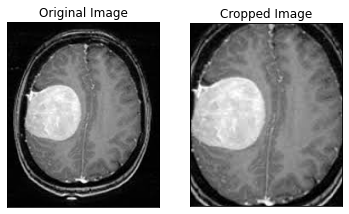

In [55]:
ex_img = cv2.imread('brain_tumor_dataset/train/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [56]:
def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [57]:
from os import listdir
import random
from os.path import join, isfile
augmented_path = 'brain_tumor_dataset/train/'
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2779
X shape is: (2779, 240, 240, 3)
y shape is: (2779, 1)


In [58]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [59]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [60]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1945
number of development examples = 417
number of test examples = 417
X_train shape: (1945, 240, 240, 3)
Y_train shape: (1945, 1)
X_val (dev) shape: (417, 240, 240, 3)
Y_val (dev) shape: (417, 1)
X_test shape: (417, 240, 240, 3)
Y_test shape: (417, 1)


In [61]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [62]:
def build_model(input_shape):
    X_input = Input(input_shape)
 
    X = ZeroPadding2D((2, 2))(X_input) 
    

    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 

    X = MaxPooling2D((4, 4), name='max_pool0')(X) 

    X = MaxPooling2D((4, 4), name='max_pool1')(X)

    X = Flatten()(X) 

    X = Dense(1, activation='sigmoid', name='fc')(X)
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [63]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [68]:
model = build_model(IMG_SHAPE)

In [69]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 244, 244, 3)      0         
 ng2D)                                                           
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_1 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [70]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
61/61 [==============================] - 224s 4s/step - loss: 0.9316 - accuracy: 0.6170 - val_loss: 0.6484 - val_accuracy: 0.6619
Epoch 2/10
61/61 [==============================] - 216s 4s/step - loss: 0.5602 - accuracy: 0.7378 - val_loss: 0.6684 - val_accuracy: 0.5827
Epoch 3/10
61/61 [==============================] - 208s 3s/step - loss: 0.5283 - accuracy: 0.7512 - val_loss: 0.5645 - val_accuracy: 0.7482
Epoch 4/10
61/61 [==============================] - 200s 3s/step - loss: 0.4675 - accuracy: 0.7887 - val_loss: 0.5292 - val_accuracy: 0.7290
Epoch 5/10
61/61 [==============================] - 202s 3s/step - loss: 0.4531 - accuracy: 0.7851 - val_loss: 0.4698 - val_accuracy: 0.7938
Epoch 6/10
61/61 [==============================] - 201s 3s/step - loss: 0.4108 - accuracy: 0.8093 - val_loss: 0.4603 - val_accuracy: 0.8010
Epoch 7/10
61/61 [==============================] - 199s 3s/step - loss: 0.3616 - accuracy: 0.8432 - val_loss: 0.7880 - val_accuracy: 0.5564
Epoch 8/10
61

In [76]:
history = model.history.history

In [77]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [78]:
plot_metrics(history) 

KeyError: 'acc'

In [79]:
loss, acc = model.evaluate(x=X_test, y=y_test)

14/14 [==============================] - 11s 771ms/step - loss: 0.4447 - accuracy: 0.8417


In [80]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.4446648955345154
Test Accuracy = 0.8417266011238098


In [81]:
y_test_prob = model.predict(X_test)

14/14 [==============================] - 12s 813ms/step


In [82]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.888135593220339


In [83]:
y_val_prob = model.predict(X_val)

14/14 [==============================] - 12s 811ms/step


In [84]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8524590163934427


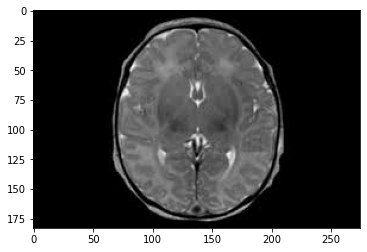

1/1 [==============================] - 0s 60ms/step
Normal


In [91]:
#Sample prediction to check the model performance on new image
image = 'brain_tumor_dataset/test/no/12 no.jpg'
img = cv2.imread(image)
plt.imshow(img)
plt.show()
img = cv2.resize(img,(240,240))
img = np.reshape(img, (1, 240, 240, 3))
classes = (model.predict(img)).astype("int32")
if(classes>=0.5):
    print("Tumor")
else:
    print("Normal")